<a href="https://colab.research.google.com/github/bedbad/GroupC-BU-COVID/blob/master/Copy_of_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
!git push origin master

fatal: not a git repository (or any of the parent directories): .git


In [ ]:
pip install snap-stanford

     |████████████████████████████████| 11.2MB 6.8MB/s 


In [ ]:
import snap

In [ ]:
# Generates a random Erdos-Renyi graph with a specified number of nodes and edges
def gen_ER_graph(nodes, edges):
    g = snap.GenRndGnm(snap.PUNGraph, nodes, edges)
    return g 

# 16,000 undergrads, 
undergrad_er = gen_ER_graph(16, 10) 

count = 0
for e in undergrad_er.Edges():
    count += 1
    # Iterate through the edges and print out the source and destination for each edge
    # print("edge: (%d, %d)" % (e.GetSrcNId(), e.GetDstNId()))
print(count)

10


In [ ]:
snap.DrawGViz(undergrad_er, snap.gvlNeato, "graph.png", "graph 1", True)


In [ ]:
! git clone https://github.com/ryansmcgee/seirsplus.git

Cloning into 'seirsplus'...
remote: Enumerating objects: 27, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 1231 (delta 13), reused 17 (delta 7), pack-reused 1204
Receiving objects: 100% (1231/1231), 25.88 MiB | 34.37 MiB/s, done.
Resolving deltas: 100% (663/663), done.


In [ ]:
! pip install networkx
# ! pwd
# ! python ../setup.py

In [ ]:
# test run of SERISPLUS
# import os, sys
# os.chdir('seirsplus/seirsplus')
# print(os.getcwd())
# from models import *
# from networks import *
# from sim_loops import *
# from utilities import *
! pip install seirsplus
from seirsplus.models import *
from seirsplus.networks import *
from seirsplus.sim_loops import *
from seirsplus.utilities import *
import networkx
import matplotlib.pyplot as pyplot

     |████████████████████████████████| 71kB 4.9MB/s 
  Created wheel for seirsplus: filename=seirsplus-1.0.9-cp36-none-any.whl size=64633 sha256=aed5a18e2d14af61e181a0c46a2261dc3b857e51d8db64a680f861c3878bd171
  Stored in directory: /root/.cache/pip/wheels/f0/83/18/7b9b20364e2740f54c21cf5b3ebfde5a8a93071e098782c705
Successfully built seirsplus


In [ ]:
# demo from https://github.com/ryansmcgee/seirsplus/blob/master/examples/Extended_SEIRS_Workplace_TTI_Demo.ipynb
NUM_COHORTS              = 4
NUM_NODES_PER_COHORT     = 200
NUM_TEAMS_PER_COHORT     = 10

MEAN_INTRACOHORT_DEGREE  = 6
PCT_CONTACTS_INTERCOHORT = 0.1

In [ ]:
N = NUM_NODES_PER_COHORT*NUM_COHORTS
INIT_EXPOSED = 4

Baseline:
Degree: mean = 11.16, std = 8.68, 95% CI = (1.00, 30.00)
        coeff var = 0.78
Assortativity:    0.26
Clustering coeff: 0.24



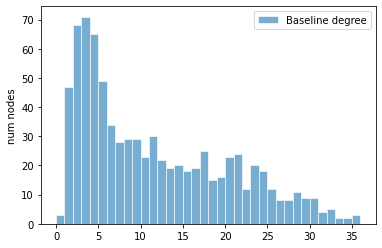

In [ ]:
G_baseline, cohorts, teams = generate_workplace_contact_network(
                                 num_cohorts=NUM_COHORTS, num_nodes_per_cohort=NUM_NODES_PER_COHORT, 
                                 num_teams_per_cohort=NUM_TEAMS_PER_COHORT,
                                 mean_intracohort_degree=MEAN_INTRACOHORT_DEGREE, 
                                 pct_contacts_intercohort=PCT_CONTACTS_INTERCOHORT,
                                 farz_params={'alpha':5.0, 'gamma':5.0, 'beta':0.5, 'r':1, 'q':0.0, 'phi':10, 
                                              'b':0, 'epsilon':1e-6, 'directed': False, 'weighted': False})

network_info(G_baseline, "Baseline", plot=True)

In [8]:
import numpy
def custom_exponential_graph(base_graph=None, scale=100, min_num_edges=0, m=9, n=None):
    # If no base graph is provided, generate a random preferential attachment power law graph as a starting point.
    if(base_graph):
        graph = base_graph.copy()
    else:
        assert(n is not None), "Argument n (number of nodes) must be provided when no base graph is given."
        graph = networkx.barabasi_albert_graph(n=n, m=m)

    # We modify the graph by probabilistically dropping some edges from each node. 
    for node in graph:
        neighbors = list(graph[node].keys())
        if(len(neighbors) > 0):
            quarantineEdgeNum = int( max(min(numpy.random.exponential(scale=scale, size=1), len(neighbors)), min_num_edges) )
            quarantineKeepNeighbors = numpy.random.choice(neighbors, size=quarantineEdgeNum, replace=False)
            for neighbor in neighbors:
                if(neighbor not in quarantineKeepNeighbors):
                    graph.remove_edge(node, neighbor)
    
    return graph

In [6]:
import scipy
import networkx
import numpy as np
import warnings

warnings.filterwarnings("ignore")

class SEIRmodel(object):

    def __init__(self, G, beta, sigma, lamda, gamma, 
                 gamma_asym=None, eta=0, gamma_H=None, mu_H=0, alpha=1.0, xi=0, mu_0=0, nu=0, a=0, h=0, f=0, p=0, 
                 beta_local=None, beta_asym=None, beta_asym_local=None, beta_pairwise_mode='infected', delta=None, delta_pairwise_mode=None,
                 G_Q=None, beta_Q=None, beta_Q_local=None, sigma_Q=None, lamda_Q=None, eta_Q=None, gamma_Q_sym=None, gamma_Q_asym=None, alpha_Q=None, delta_Q=None,
                 theta_S=0, theta_E=0, theta_pre=0, theta_sym=0, theta_asym=0, phi_S=0, phi_E=0, phi_pre=0, phi_sym=0, phi_asym=0,
                 psi_S=0, psi_E=1, psi_pre=1, psi_sym=1, psi_asym=1, q=0, isolation_time=14, 
                 initE=0, initI_pre=0, initI_sym=0, initI_asym=0, initH=0, initR=0, initF=0, 
                 initQ_S=0, initQ_E=0, initQ_pre=0, initQ_sym=0, initQ_asym=0, initQ_R=0, 
                 o=0, prevalence_ext=0, 
                 transition_mode='exponential_rates', node_groups=None, store_Xseries=False, seed=None):
        # Create random seed
        if(seed is not None):
            np.random.seed(seed)
            self.seed = seed
        
        # store parameters in dict
        self.parameters = { 'G':G, 'G_Q':G_Q,
                            'beta':beta, 'sigma':sigma, 'lamda':lamda, 'gamma':gamma, 
                            'eta':eta, 'gamma_asym':gamma_asym, 'gamma_H':gamma_H, 'mu_H':mu_H, 
                            'xi':xi, 'mu_0':mu_0, 'nu':nu, 'a':a, 'h':h, 'f':f, 'p':p, 
                            'beta_local':beta_local, 'beta_asym':beta_asym, 'beta_asym_local':beta_asym_local, 'beta_pairwise_mode':beta_pairwise_mode,
                            'alpha':alpha, 'delta':delta, 'delta_pairwise_mode':delta_pairwise_mode,
                            'lamda_Q':lamda_Q, 'beta_Q':beta_Q, 'beta_Q_local':beta_Q_local, 'alpha_Q':alpha_Q, 'sigma_Q':sigma_Q, 
                            'eta_Q':eta_Q, 'gamma_Q_sym':gamma_Q_sym, 'gamma_Q_asym':gamma_Q_asym, 'delta_Q':delta_Q,
                            'theta_S':theta_S, 'theta_E':theta_E, 'theta_pre':theta_pre, 'theta_sym':theta_sym, 'theta_asym':theta_asym, 
                            'phi_S':phi_S, 'phi_E':phi_E, 'phi_pre':phi_pre, 'phi_sym':phi_sym, 'phi_asym':phi_asym, 
                            'psi_S':psi_S, 'psi_E':psi_E, 'psi_pre':psi_pre, 'psi_sym':psi_sym, 'psi_asym':psi_asym, 'q':q, 'isolation_time':isolation_time,
                            'initE':initE, 'initI_pre':initI_pre, 'initI_sym':initI_sym, 'initI_asym':initI_asym, 
                            'initH':initH, 'initR':initR, 'initF':initF, 
                            'initQ_S':initQ_S, 'initQ_E':initQ_E, 'initQ_pre':initQ_pre, 
                            'initQ_sym':initQ_sym, 'initQ_asym':initQ_asym, 'initQ_R':initQ_R,
                            'o':o, 'prevalence_ext':prevalence_ext}
        
        # processing parameters
        self.update_parameters()
        
        self.tseries    = np.zeros(6*self.numNodes)
        self.numS       = np.zeros(6*self.numNodes)
        self.numE       = np.zeros(6*self.numNodes)
        self.numI_pre   = np.zeros(6*self.numNodes)
        self.numI_sym   = np.zeros(6*self.numNodes)
        self.numI_asym  = np.zeros(6*self.numNodes)
        self.numH       = np.zeros(6*self.numNodes)
        self.numR       = np.zeros(6*self.numNodes)
        self.numF       = np.zeros(6*self.numNodes)
        self.numQ_S     = np.zeros(6*self.numNodes)
        self.numQ_E     = np.zeros(6*self.numNodes)
        self.numQ_pre   = np.zeros(6*self.numNodes)
        self.numQ_sym   = np.zeros(6*self.numNodes)
        self.numQ_asym  = np.zeros(6*self.numNodes)
        self.numQ_R     = np.zeros(6*self.numNodes)
        self.N          = np.zeros(6*self.numNodes)

        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        # Initialize Timekeeping:
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        self.t          = 0
        self.tmax       = 0 # will be set when run() is called
        self.tidx       = 0
        self.tseries[0] = 0

        # Vectors holding the time that each node has been in a given state or in isolation:
        self.timer_state     = np.zeros((self.numNodes,1))
        self.timer_isolation = np.zeros(self.numNodes)
        self.isolationTime   = isolation_time
        
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        # Initialize Counts of inidividuals with each state:
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        self.numE[0]        = int(initE)
        self.numI_pre[0]    = int(initI_pre)
        self.numI_sym[0]    = int(initI_sym)
        self.numI_asym[0]   = int(initI_asym)
        self.numH[0]        = int(initH)
        self.numR[0]        = int(initR)
        self.numF[0]        = int(initF)
        self.numQ_S[0]      = int(initQ_S)
        self.numQ_E[0]      = int(initQ_E)
        self.numQ_pre[0]    = int(initQ_pre)
        self.numQ_sym[0]    = int(initQ_sym)
        self.numQ_asym[0]   = int(initQ_asym)
        self.numQ_R[0]      = int(initQ_R)
        self.numS[0]        = (self.numNodes - self.numE[0] - self.numI_pre[0] - self.numI_sym[0] - self.numI_asym[0] - self.numH[0] - self.numR[0] 
                                             - self.numQ_S[0] - self.numQ_E[0] - self.numQ_pre[0] - self.numQ_sym[0] - self.numQ_asym[0] - self.numQ_R[0] - self.numF[0])
        self.N[0]           = self.numNodes - self.numF[0]

        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        # Node states:
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        self.S          = 1
        self.E          = 2
        self.I_pre      = 3
        self.I_sym      = 4
        self.I_asym     = 5
        self.H          = 6
        self.R          = 7
        self.F          = 8
        self.Q_S        = 11
        self.Q_E        = 12
        self.Q_pre      = 13
        self.Q_sym      = 14
        self.Q_asym     = 15
        self.Q_R        = 17
        
        self.X = np.array( [self.S]*int(self.numS[0]) + [self.E]*int(self.numE[0]) 
                               + [self.I_pre]*int(self.numI_pre[0]) + [self.I_sym]*int(self.numI_sym[0]) + [self.I_asym]*int(self.numI_asym[0]) 
                               + [self.H]*int(self.numH[0]) + [self.R]*int(self.numR[0]) + [self.F]*int(self.numF[0])
                               + [self.Q_S]*int(self.numQ_S[0]) + [self.Q_E]*int(self.numQ_E[0]) 
                               + [self.Q_pre]*int(self.numQ_pre[0]) + [self.Q_sym]*int(self.numQ_sym[0]) + [self.Q_asym]*int(self.numQ_asym[0]) 
                               + [self.Q_R]*int(self.numQ_R[0])
                            ).reshape((self.numNodes,1))
        np.random.shuffle(self.X)

        self.store_Xseries = store_Xseries
        if(store_Xseries):
            self.Xseries        = np.zeros(shape=(6*self.numNodes, self.numNodes), dtype='uint8')
            self.Xseries[0,:]   = self.X.T

        self.transitions =  { 
                                'StoE':         {'currentState':self.S,       'newState':self.E},
                                'StoQS':        {'currentState':self.S,       'newState':self.Q_S},
                                'EtoIPRE':      {'currentState':self.E,       'newState':self.I_pre},
                                'EtoQE':        {'currentState':self.E,       'newState':self.Q_E},
                                'IPREtoISYM':   {'currentState':self.I_pre,   'newState':self.I_sym},
                                'IPREtoIASYM':  {'currentState':self.I_pre,   'newState':self.I_asym},
                                'IPREtoQPRE':   {'currentState':self.I_pre,   'newState':self.Q_pre},
                                'ISYMtoH':      {'currentState':self.I_sym,   'newState':self.H},
                                'ISYMtoR':      {'currentState':self.I_sym,   'newState':self.R},
                                'ISYMtoQSYM':   {'currentState':self.I_sym,   'newState':self.Q_sym},
                                'IASYMtoR':     {'currentState':self.I_asym,  'newState':self.R},
                                'IASYMtoQASYM': {'currentState':self.I_asym,  'newState':self.Q_asym},
                                'HtoR':         {'currentState':self.H,       'newState':self.R},
                                'HtoF':         {'currentState':self.H,       'newState':self.F},
                                'RtoS':         {'currentState':self.R,       'newState':self.S},
                                'QStoQE':       {'currentState':self.Q_S,     'newState':self.Q_E},
                                'QEtoQPRE':     {'currentState':self.Q_E,     'newState':self.Q_pre},
                                'QPREtoQSYM':   {'currentState':self.Q_pre,   'newState':self.Q_sym},
                                'QPREtoQASYM':  {'currentState':self.Q_pre,   'newState':self.Q_asym},
                                'QSYMtoH':      {'currentState':self.Q_sym,   'newState':self.H},
                                'QSYMtoQR':     {'currentState':self.Q_sym,   'newState':self.Q_R},
                                'QASYMtoQR':    {'currentState':self.Q_asym,  'newState':self.Q_R},
                                '_toS':         {'currentState':True,         'newState':self.S},
                            }

        self.transition_mode = transition_mode

        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        # Initialize other node metadata:
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        self.tested      = np.array([False]*self.numNodes).reshape((self.numNodes,1))
        self.positive    = np.array([False]*self.numNodes).reshape((self.numNodes,1))
        self.numTested   = np.zeros(6*self.numNodes) 
        self.numPositive = np.zeros(6*self.numNodes) 

        self.testedInCurrentState = np.array([False]*self.numNodes).reshape((self.numNodes,1))

        self.infectionsLog = []

        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        # Initialize node subgroup data series:
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        self.nodeGroupData = None
        if(node_groups):
            self.nodeGroupData = {}
            for groupName, nodeList in node_groups.items():
                self.nodeGroupData[groupName] = {'nodes':   np.array(nodeList),
                                                 'mask':    np.isin(range(self.numNodes), nodeList).reshape((self.numNodes,1))}
                self.nodeGroupData[groupName]['numS']           = np.zeros(6*self.numNodes)
                self.nodeGroupData[groupName]['numE']           = np.zeros(6*self.numNodes)
                self.nodeGroupData[groupName]['numI_pre']       = np.zeros(6*self.numNodes)
                self.nodeGroupData[groupName]['numI_sym']       = np.zeros(6*self.numNodes)
                self.nodeGroupData[groupName]['numI_asym']      = np.zeros(6*self.numNodes)
                self.nodeGroupData[groupName]['numH']           = np.zeros(6*self.numNodes)
                self.nodeGroupData[groupName]['numR']           = np.zeros(6*self.numNodes)
                self.nodeGroupData[groupName]['numF']           = np.zeros(6*self.numNodes)
                self.nodeGroupData[groupName]['numQ_S']         = np.zeros(6*self.numNodes)
                self.nodeGroupData[groupName]['numQ_E']         = np.zeros(6*self.numNodes)
                self.nodeGroupData[groupName]['numQ_pre']       = np.zeros(6*self.numNodes)
                self.nodeGroupData[groupName]['numQ_sym']       = np.zeros(6*self.numNodes)
                self.nodeGroupData[groupName]['numQ_asym']      = np.zeros(6*self.numNodes)
                self.nodeGroupData[groupName]['numQ_R']         = np.zeros(6*self.numNodes)
                self.nodeGroupData[groupName]['N']              = np.zeros(6*self.numNodes)
                self.nodeGroupData[groupName]['numPositive']    = np.zeros(6*self.numNodes)
                self.nodeGroupData[groupName]['numTested']      = np.zeros(6*self.numNodes)
                self.nodeGroupData[groupName]['numS'][0]        = np.count_nonzero(self.nodeGroupData[groupName]['mask']*self.X==self.S)
                self.nodeGroupData[groupName]['numE'][0]        = np.count_nonzero(self.nodeGroupData[groupName]['mask']*self.X==self.E)
                self.nodeGroupData[groupName]['numI_pre'][0]    = np.count_nonzero(self.nodeGroupData[groupName]['mask']*self.X==self.I_pre)
                self.nodeGroupData[groupName]['numI_sym'][0]    = np.count_nonzero(self.nodeGroupData[groupName]['mask']*self.X==self.I_sym)
                self.nodeGroupData[groupName]['numI_asym'][0]   = np.count_nonzero(self.nodeGroupData[groupName]['mask']*self.X==self.I_asym)
                self.nodeGroupData[groupName]['numH'][0]        = np.count_nonzero(self.nodeGroupData[groupName]['mask']*self.X==self.H)
                self.nodeGroupData[groupName]['numR'][0]        = np.count_nonzero(self.nodeGroupData[groupName]['mask']*self.X==self.R)
                self.nodeGroupData[groupName]['numF'][0]        = np.count_nonzero(self.nodeGroupData[groupName]['mask']*self.X==self.F)
                self.nodeGroupData[groupName]['numQ_S'][0]      = np.count_nonzero(self.nodeGroupData[groupName]['mask']*self.X==self.Q_E)
                self.nodeGroupData[groupName]['numQ_E'][0]      = np.count_nonzero(self.nodeGroupData[groupName]['mask']*self.X==self.Q_E)
                self.nodeGroupData[groupName]['numQ_pre'][0]    = np.count_nonzero(self.nodeGroupData[groupName]['mask']*self.X==self.Q_pre)
                self.nodeGroupData[groupName]['numQ_I_sym'][0]  = np.count_nonzero(self.nodeGroupData[groupName]['mask']*self.X==self.Q_I_sym)
                self.nodeGroupData[groupName]['numQ_I_asym'][0] = np.count_nonzero(self.nodeGroupData[groupName]['mask']*self.X==self.Q_I_asym)
                self.nodeGroupData[groupName]['numQ_R'][0]      = np.count_nonzero(self.nodeGroupData[groupName]['mask']*self.X==self.Q_E)
                self.nodeGroupData[groupName]['N'][0]           = self.numNodes - self.numF[0]

    
    def update_parameters(self):

        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        # Model graphs:
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        self.G = self.parameters['G']
        # Adjacency matrix:
        if type(self.G)==np.ndarray:
            self.A = scipy.sparse.csr_matrix(self.G)
        elif type(self.G)==networkx.classes.graph.Graph:
            self.A = networkx.adj_matrix(self.G) # adj_matrix gives scipy.sparse csr_matrix
        else:
            raise BaseException("Input an adjacency matrix or networkx object only.")
        self.numNodes   = int(self.A.shape[1])
        self.degree     = np.asarray(self.node_degrees(self.A)).astype(float)
        #----------------------------------------
        if(self.parameters['G_Q'] is None):
            self.G_Q = self.G # If no Q graph is provided, use G in its place
        else:
            self.G_Q = self.parameters['G_Q']
        # Quarantine Adjacency matrix:
        if type(self.G_Q)==np.ndarray:
            self.A_Q = scipy.sparse.csr_matrix(self.G_Q)
        elif type(self.G_Q)==networkx.classes.graph.Graph:
            self.A_Q = networkx.adj_matrix(self.G_Q) # adj_matrix gives scipy.sparse csr_matrix
        else:
            raise BaseException("Input an adjacency matrix or networkx object only.")
        self.numNodes_Q   = int(self.A_Q.shape[1])
        self.degree_Q     = np.asarray(self.node_degrees(self.A_Q)).astype(float)
        #----------------------------------------
        assert(self.numNodes == self.numNodes_Q), "The normal and quarantine adjacency graphs must be of the same size."

        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        # Model parameters:
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        self.beta           = np.array(self.parameters['beta']).reshape((self.numNodes, 1))          if isinstance(self.parameters['beta'], (list, np.ndarray)) else np.full(fill_value=self.parameters['beta'], shape=(self.numNodes,1))
        self.beta_asym      = (np.array(self.parameters['beta_asym']).reshape((self.numNodes, 1))    if isinstance(self.parameters['beta_asym'], (list, np.ndarray)) else np.full(fill_value=self.parameters['beta_asym'], shape=(self.numNodes,1))) if self.parameters['beta_asym'] is not None else self.beta
        self.sigma          = np.array(self.parameters['sigma']).reshape((self.numNodes, 1))         if isinstance(self.parameters['sigma'], (list, np.ndarray)) else np.full(fill_value=self.parameters['sigma'], shape=(self.numNodes,1))
        self.lamda          = np.array(self.parameters['lamda']).reshape((self.numNodes, 1))         if isinstance(self.parameters['lamda'], (list, np.ndarray)) else np.full(fill_value=self.parameters['lamda'], shape=(self.numNodes,1))
        self.gamma          = np.array(self.parameters['gamma']).reshape((self.numNodes, 1))         if isinstance(self.parameters['gamma'], (list, np.ndarray)) else np.full(fill_value=self.parameters['gamma'], shape=(self.numNodes,1))
        self.eta            = np.array(self.parameters['eta']).reshape((self.numNodes, 1))           if isinstance(self.parameters['eta'], (list, np.ndarray)) else np.full(fill_value=self.parameters['eta'], shape=(self.numNodes,1))
        self.gamma_asym     = (np.array(self.parameters['gamma_asym']).reshape((self.numNodes, 1))   if isinstance(self.parameters['gamma_asym'], (list, np.ndarray)) else np.full(fill_value=self.parameters['gamma_asym'], shape=(self.numNodes,1))) if self.parameters['gamma_asym'] is not None else self.gamma
        self.gamma_H        = (np.array(self.parameters['gamma_H']).reshape((self.numNodes, 1))      if isinstance(self.parameters['gamma_H'], (list, np.ndarray)) else np.full(fill_value=self.parameters['gamma_H'], shape=(self.numNodes,1))) if self.parameters['gamma_H'] is not None else self.gamma
        self.mu_H           = np.array(self.parameters['mu_H']).reshape((self.numNodes, 1))          if isinstance(self.parameters['mu_H'], (list, np.ndarray)) else np.full(fill_value=self.parameters['mu_H'], shape=(self.numNodes,1))
        self.alpha          = np.array(self.parameters['alpha']).reshape((self.numNodes, 1))         if isinstance(self.parameters['alpha'], (list, np.ndarray)) else np.full(fill_value=self.parameters['alpha'], shape=(self.numNodes,1))
        self.xi             = np.array(self.parameters['xi']).reshape((self.numNodes, 1))            if isinstance(self.parameters['xi'], (list, np.ndarray)) else np.full(fill_value=self.parameters['xi'], shape=(self.numNodes,1))
        self.mu_0           = np.array(self.parameters['mu_0']).reshape((self.numNodes, 1))          if isinstance(self.parameters['mu_0'], (list, np.ndarray)) else np.full(fill_value=self.parameters['mu_0'], shape=(self.numNodes,1))
        self.nu             = np.array(self.parameters['nu']).reshape((self.numNodes, 1))            if isinstance(self.parameters['nu'], (list, np.ndarray)) else np.full(fill_value=self.parameters['nu'], shape=(self.numNodes,1))
        self.a              = np.array(self.parameters['a']).reshape((self.numNodes, 1))             if isinstance(self.parameters['a'], (list, np.ndarray)) else np.full(fill_value=self.parameters['a'], shape=(self.numNodes,1))
        self.h              = np.array(self.parameters['h']).reshape((self.numNodes, 1))             if isinstance(self.parameters['h'], (list, np.ndarray)) else np.full(fill_value=self.parameters['h'], shape=(self.numNodes,1))
        self.f              = np.array(self.parameters['f']).reshape((self.numNodes, 1))             if isinstance(self.parameters['f'], (list, np.ndarray)) else np.full(fill_value=self.parameters['f'], shape=(self.numNodes,1))
        self.p              = np.array(self.parameters['p']).reshape((self.numNodes, 1))             if isinstance(self.parameters['p'], (list, np.ndarray)) else np.full(fill_value=self.parameters['p'], shape=(self.numNodes,1))
        self.o              = np.array(self.parameters['o']).reshape((self.numNodes, 1))             if isinstance(self.parameters['o'], (list, np.ndarray)) else np.full(fill_value=self.parameters['o'], shape=(self.numNodes,1))

        self.rand_a = np.random.rand(self.a.shape[0], self.a.shape[1])
        self.rand_h = np.random.rand(self.h.shape[0], self.h.shape[1])
        self.rand_f = np.random.rand(self.f.shape[0], self.f.shape[1])

        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        # External infection introduction variables:
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        self.prevalence_ext     = np.array(self.parameters['prevalence_ext']).reshape((self.numNodes, 1)) if isinstance(self.parameters['prevalence_ext'], (list, np.ndarray)) else np.full(fill_value=self.parameters['prevalence_ext'], shape=(self.numNodes,1))
       
        #----------------------------------------
        # Testing-related parameters:
        #----------------------------------------
        self.beta_Q         = (np.array(self.parameters['beta_Q']).reshape((self.numNodes, 1))       if isinstance(self.parameters['beta_Q'], (list, np.ndarray)) else np.full(fill_value=self.parameters['beta_Q'], shape=(self.numNodes,1))) if self.parameters['beta_Q'] is not None else self.beta
        self.sigma_Q        = (np.array(self.parameters['sigma_Q']).reshape((self.numNodes, 1))      if isinstance(self.parameters['sigma_Q'], (list, np.ndarray)) else np.full(fill_value=self.parameters['sigma_Q'], shape=(self.numNodes,1))) if self.parameters['sigma_Q'] is not None else self.sigma
        self.lamda_Q        = (np.array(self.parameters['lamda_Q']).reshape((self.numNodes, 1))      if isinstance(self.parameters['lamda_Q'], (list, np.ndarray)) else np.full(fill_value=self.parameters['lamda_Q'], shape=(self.numNodes,1))) if self.parameters['lamda_Q'] is not None else self.lamda
        self.gamma_Q_sym    = (np.array(self.parameters['gamma_Q_sym']).reshape((self.numNodes, 1))  if isinstance(self.parameters['gamma_Q_sym'], (list, np.ndarray)) else np.full(fill_value=self.parameters['gamma_Q_sym'], shape=(self.numNodes,1))) if self.parameters['gamma_Q_sym'] is not None else self.gamma
        self.gamma_Q_asym   = (np.array(self.parameters['gamma_Q_asym']).reshape((self.numNodes, 1)) if isinstance(self.parameters['gamma_Q_asym'], (list, np.ndarray)) else np.full(fill_value=self.parameters['gamma_Q_asym'], shape=(self.numNodes,1))) if self.parameters['gamma_Q_asym'] is not None else self.gamma
        self.eta_Q          = (np.array(self.parameters['eta_Q']).reshape((self.numNodes, 1))        if isinstance(self.parameters['eta_Q'], (list, np.ndarray)) else np.full(fill_value=self.parameters['eta_Q'], shape=(self.numNodes,1))) if self.parameters['eta_Q'] is not None else self.eta
        self.alpha_Q        = (np.array(self.parameters['alpha_Q']).reshape((self.numNodes, 1))      if isinstance(self.parameters['alpha_Q'], (list, np.ndarray)) else np.full(fill_value=self.parameters['alpha_Q'], shape=(self.numNodes,1))) if self.parameters['alpha_Q'] is not None else self.alpha
        self.theta_S        = np.array(self.parameters['theta_S']).reshape((self.numNodes, 1))       if isinstance(self.parameters['theta_S'], (list, np.ndarray)) else np.full(fill_value=self.parameters['theta_S'], shape=(self.numNodes,1))
        self.theta_E        = np.array(self.parameters['theta_E']).reshape((self.numNodes, 1))       if isinstance(self.parameters['theta_E'], (list, np.ndarray)) else np.full(fill_value=self.parameters['theta_E'], shape=(self.numNodes,1))
        self.theta_pre      = np.array(self.parameters['theta_pre']).reshape((self.numNodes, 1))     if isinstance(self.parameters['theta_pre'], (list, np.ndarray)) else np.full(fill_value=self.parameters['theta_pre'], shape=(self.numNodes,1))
        self.theta_sym      = np.array(self.parameters['theta_sym']).reshape((self.numNodes, 1))     if isinstance(self.parameters['theta_sym'], (list, np.ndarray)) else np.full(fill_value=self.parameters['theta_sym'], shape=(self.numNodes,1))
        self.theta_asym     = np.array(self.parameters['theta_asym']).reshape((self.numNodes, 1))    if isinstance(self.parameters['theta_asym'], (list, np.ndarray)) else np.full(fill_value=self.parameters['theta_asym'], shape=(self.numNodes,1))
        self.phi_S          = np.array(self.parameters['phi_S']).reshape((self.numNodes, 1))         if isinstance(self.parameters['phi_S'], (list, np.ndarray)) else np.full(fill_value=self.parameters['phi_S'], shape=(self.numNodes,1))
        self.phi_E          = np.array(self.parameters['phi_E']).reshape((self.numNodes, 1))         if isinstance(self.parameters['phi_E'], (list, np.ndarray)) else np.full(fill_value=self.parameters['phi_E'], shape=(self.numNodes,1))
        self.phi_pre        = np.array(self.parameters['phi_pre']).reshape((self.numNodes, 1))       if isinstance(self.parameters['phi_pre'], (list, np.ndarray)) else np.full(fill_value=self.parameters['phi_pre'], shape=(self.numNodes,1))
        self.phi_sym        = np.array(self.parameters['phi_sym']).reshape((self.numNodes, 1))       if isinstance(self.parameters['phi_sym'], (list, np.ndarray)) else np.full(fill_value=self.parameters['phi_sym'], shape=(self.numNodes,1))
        self.phi_asym       = np.array(self.parameters['phi_asym']).reshape((self.numNodes, 1))      if isinstance(self.parameters['phi_asym'], (list, np.ndarray)) else np.full(fill_value=self.parameters['phi_asym'], shape=(self.numNodes,1))
        self.psi_S            = np.array(self.parameters['psi_S']).reshape((self.numNodes, 1))           if isinstance(self.parameters['psi_S'], (list, np.ndarray)) else np.full(fill_value=self.parameters['psi_S'], shape=(self.numNodes,1))
        self.psi_E            = np.array(self.parameters['psi_E']).reshape((self.numNodes, 1))           if isinstance(self.parameters['psi_E'], (list, np.ndarray)) else np.full(fill_value=self.parameters['psi_E'], shape=(self.numNodes,1))
        self.psi_pre          = np.array(self.parameters['psi_pre']).reshape((self.numNodes, 1))         if isinstance(self.parameters['psi_pre'], (list, np.ndarray)) else np.full(fill_value=self.parameters['psi_pre'], shape=(self.numNodes,1))
        self.psi_sym          = np.array(self.parameters['psi_sym']).reshape((self.numNodes, 1))         if isinstance(self.parameters['psi_sym'], (list, np.ndarray)) else np.full(fill_value=self.parameters['psi_sym'], shape=(self.numNodes,1))
        self.psi_asym         = np.array(self.parameters['psi_asym']).reshape((self.numNodes, 1))        if isinstance(self.parameters['psi_asym'], (list, np.ndarray)) else np.full(fill_value=self.parameters['psi_asym'], shape=(self.numNodes,1))
        self.q              = np.array(self.parameters['q']).reshape((self.numNodes, 1))             if isinstance(self.parameters['q'], (list, np.ndarray)) else np.full(fill_value=self.parameters['q'], shape=(self.numNodes,1))

        #----------------------------------------

        self.beta_pairwise_mode = self.parameters['beta_pairwise_mode']

        #----------------------------------------
        # Global transmission parameters:
        #----------------------------------------
        if(self.beta_pairwise_mode == 'infected' or self.beta_pairwise_mode is None):
            self.beta_global         = np.full_like(self.beta, fill_value=np.mean(self.beta))
            self.beta_Q_global       = np.full_like(self.beta_Q, fill_value=np.mean(self.beta_Q))
            self.beta_asym_global    = np.full_like(self.beta_asym, fill_value=np.mean(self.beta_asym))
        elif(self.beta_pairwise_mode == 'infectee'):
            self.beta_global         = self.beta      
            self.beta_Q_global       = self.beta_Q    
            self.beta_asym_global    = self.beta_asym
        elif(self.beta_pairwise_mode == 'min'):
            self.beta_global         = np.minimum(self.beta, np.mean(beta)) 
            self.beta_Q_global       = np.minimum(self.beta_Q, np.mean(beta_Q)) 
            self.beta_asym_global    = np.minimum(self.beta_asym, np.mean(beta_asym))
        elif(self.beta_pairwise_mode == 'max'):
            self.beta_global         = np.maximum(self.beta, np.mean(beta)) 
            self.beta_Q_global       = np.maximum(self.beta_Q, np.mean(beta_Q)) 
            self.beta_asym_global    = np.maximum(self.beta_asym, np.mean(beta_asym))
        elif(self.beta_pairwise_mode == 'mean'):
            self.beta_global         = (self.beta + np.full_like(self.beta, fill_value=np.mean(self.beta)))/2
            self.beta_Q_global       = (self.beta_Q + np.full_like(self.beta_Q, fill_value=np.mean(self.beta_Q)))/2
            self.beta_asym_global    = (self.beta_asym + np.full_like(self.beta_asym, fill_value=np.mean(self.beta_asym)))/2
            
        #----------------------------------------
        # Local transmission parameters:
        #----------------------------------------
        self.beta_local         = self.beta      if self.parameters['beta_local'] is None      else np.array(self.parameters['beta_local'])      if isinstance(self.parameters['beta_local'], (list, np.ndarray))      else np.full(fill_value=self.parameters['beta_local'], shape=(self.numNodes,1))
        self.beta_Q_local       = self.beta_Q    if self.parameters['beta_Q_local'] is None    else np.array(self.parameters['beta_Q_local'])    if isinstance(self.parameters['beta_Q_local'], (list, np.ndarray))    else np.full(fill_value=self.parameters['beta_Q_local'], shape=(self.numNodes,1))
        self.beta_asym_local    = None           if self.parameters['beta_asym_local'] is None else np.array(self.parameters['beta_asym_local']) if isinstance(self.parameters['beta_asym_local'], (list, np.ndarray)) else np.full(fill_value=self.parameters['beta_asym_local'], shape=(self.numNodes,1))
        #----------------------------------------
        if(self.beta_local.ndim == 2 and self.beta_local.shape[0] == self.numNodes and self.beta_local.shape[1] == self.numNodes):
            self.A_beta_pairwise = self.beta_local
        elif((self.beta_local.ndim == 1 and self.beta_local.shape[0] == self.numNodes) or (self.beta_local.ndim == 2 and (self.beta_local.shape[0] == self.numNodes or self.beta_local.shape[1] == self.numNodes))):
            self.beta_local = self.beta_local.reshape((self.numNodes,1))
            # Pre-multiply beta values by the adjacency matrix ("transmission weight connections")
            A_beta_pairwise_byInfected = scipy.sparse.csr_matrix.multiply(self.A, self.beta_local.T).tocsr()
            A_beta_pairwise_byInfectee = scipy.sparse.csr_matrix.multiply(self.A, self.beta_local).tocsr()    
            #------------------------------
            # Compute the effective pairwise beta values as a function of the infected/infectee pair:
            if(self.beta_pairwise_mode == 'infected'):
                self.A_beta_pairwise = A_beta_pairwise_byInfected
            elif(self.beta_pairwise_mode == 'infectee'):
                self.A_beta_pairwise = A_beta_pairwise_byInfectee
            elif(self.beta_pairwise_mode == 'min'):
                self.A_beta_pairwise = scipy.sparse.csr_matrix.minimum(A_beta_pairwise_byInfected, A_beta_pairwise_byInfectee)
            elif(self.beta_pairwise_mode == 'max'):
                self.A_beta_pairwise = scipy.sparse.csr_matrix.maximum(A_beta_pairwise_byInfected, A_beta_pairwise_byInfectee)
            elif(self.beta_pairwise_mode == 'mean' or self.beta_pairwise_mode is None):
                self.A_beta_pairwise = (A_beta_pairwise_byInfected + A_beta_pairwise_byInfectee)/2
            else:
                print("Unrecognized beta_pairwise_mode value (support for 'infected', 'infectee', 'min', 'max', and 'mean').")
        else:
            print("Invalid values given for beta_local (expected 1xN list/array or NxN 2d array)")
        #----------------------------------------
        if(self.beta_Q_local.ndim == 2 and self.beta_Q_local.shape[0] == self.numNodes and self.beta_Q_local.shape[1] == self.numNodes):
            self.A_Q_beta_Q_pairwise = self.beta_Q_local
        elif((self.beta_Q_local.ndim == 1 and self.beta_Q_local.shape[0] == self.numNodes) or (self.beta_Q_local.ndim == 2 and (self.beta_Q_local.shape[0] == self.numNodes or self.beta_Q_local.shape[1] == self.numNodes))):
            self.beta_Q_local = self.beta_Q_local.reshape((self.numNodes,1))
            # Pre-multiply beta_Q values by the isolation adjacency matrix ("transmission weight connections")
            A_Q_beta_Q_pairwise_byInfected      = scipy.sparse.csr_matrix.multiply(self.A_Q, self.beta_Q_local.T).tocsr()
            A_Q_beta_Q_pairwise_byInfectee      = scipy.sparse.csr_matrix.multiply(self.A_Q, self.beta_Q_local).tocsr()
            #------------------------------
            # Compute the effective pairwise beta values as a function of the infected/infectee pair:
            if(self.beta_pairwise_mode == 'infected'):
                self.A_Q_beta_Q_pairwise = A_Q_beta_Q_pairwise_byInfected
            elif(self.beta_pairwise_mode == 'infectee'):
                self.A_Q_beta_Q_pairwise = A_Q_beta_Q_pairwise_byInfectee
            elif(self.beta_pairwise_mode == 'min'):
                self.A_Q_beta_Q_pairwise = scipy.sparse.csr_matrix.minimum(A_Q_beta_Q_pairwise_byInfected, A_Q_beta_Q_pairwise_byInfectee)
            elif(self.beta_pairwise_mode == 'max'):
                self.A_Q_beta_Q_pairwise = scipy.sparse.csr_matrix.maximum(A_Q_beta_Q_pairwise_byInfected, A_Q_beta_Q_pairwise_byInfectee)
            elif(self.beta_pairwise_mode == 'mean' or self.beta_pairwise_mode is None):
                self.A_Q_beta_Q_pairwise = (A_Q_beta_Q_pairwise_byInfected + A_Q_beta_Q_pairwise_byInfectee)/2
            else:
                print("Unrecognized beta_pairwise_mode value (support for 'infected', 'infectee', 'min', 'max', and 'mean').")
        else:
            print("Invalid values given for beta_Q_local (expected 1xN list/array or NxN 2d array)")
        #----------------------------------------
        if(self.beta_asym_local is None):
            self.A_beta_asym_pairwise = None
        elif(self.beta_asym_local.ndim == 2 and self.beta_asym_local.shape[0] == self.numNodes and self.beta_asym_local.shape[1] == self.numNodes):
            self.A_beta_asym_pairwise = self.beta_asym_local
        elif((self.beta_asym_local.ndim == 1 and self.beta_asym_local.shape[0] == self.numNodes) or (self.beta_asym_local.ndim == 2 and (self.beta_asym_local.shape[0] == self.numNodes or self.beta_asym_local.shape[1] == self.numNodes))):
            self.beta_asym_local = self.beta_asym_local.reshape((self.numNodes,1))
            # Pre-multiply beta_asym values by the adjacency matrix ("transmission weight connections")
            A_beta_asym_pairwise_byInfected      = scipy.sparse.csr_matrix.multiply(self.A, self.beta_asym_local.T).tocsr()
            A_beta_asym_pairwise_byInfectee      = scipy.sparse.csr_matrix.multiply(self.A, self.beta_asym_local).tocsr()
            #------------------------------
            # Compute the effective pairwise beta values as a function of the infected/infectee pair:
            if(self.beta_pairwise_mode == 'infected'):
                self.A_beta_asym_pairwise = A_beta_asym_pairwise_byInfected
            elif(self.beta_pairwise_mode == 'infectee'):
                self.A_beta_asym_pairwise = A_beta_asym_pairwise_byInfectee
            elif(self.beta_pairwise_mode == 'min'):
                self.A_beta_asym_pairwise = scipy.sparse.csr_matrix.minimum(A_beta_asym_pairwise_byInfected, A_beta_asym_pairwise_byInfectee)
            elif(self.beta_pairwise_mode == 'max'):
                self.A_beta_asym_pairwise = scipy.sparse.csr_matrix.maximum(A_beta_asym_pairwise_byInfected, A_beta_asym_pairwise_byInfectee)
            elif(self.beta_pairwise_mode == 'mean' or self.beta_pairwise_mode is None):
                self.A_beta_asym_pairwise = (A_beta_asym_pairwise_byInfected + A_beta_asym_pairwise_byInfectee)/2
            else:
                print("Unrecognized beta_pairwise_mode value (support for 'infected', 'infectee', 'min', 'max', and 'mean').")
        else:
            print("Invalid values given for beta_asym_local (expected 1xN list/array or NxN 2d array)")

        #----------------------------------------
        # Degree-based transmission scaling parameters:
        #----------------------------------------
        self.delta_pairwise_mode = self.parameters['delta_pairwise_mode']
        self.delta               = np.log(self.degree)/np.log(np.mean(self.degree))     if self.parameters['delta'] is None   else np.array(self.parameters['delta'])   if isinstance(self.parameters['delta'], (list, np.ndarray))   else np.full(fill_value=self.parameters['delta'], shape=(self.numNodes,1))
        self.delta_Q             = np.log(self.degree_Q)/np.log(np.mean(self.degree_Q)) if self.parameters['delta_Q'] is None else np.array(self.parameters['delta_Q']) if isinstance(self.parameters['delta_Q'], (list, np.ndarray)) else np.full(fill_value=self.parameters['delta_Q'], shape=(self.numNodes,1))
        #----------------------------------------
        if(self.delta.ndim == 2 and self.delta.shape[0] == self.numNodes and self.delta.shape[1] == self.numNodes):
            self.A_delta_pairwise = self.delta
        elif((self.delta.ndim == 1 and self.delta.shape[0] == self.numNodes) or (self.delta.ndim == 2 and (self.delta.shape[0] == self.numNodes or self.delta.shape[1] == self.numNodes))):
            self.delta = self.delta.reshape((self.numNodes,1))
            # Pre-multiply delta values by the adjacency matrix ("transmission weight connections")
            A_delta_pairwise_byInfected = scipy.sparse.csr_matrix.multiply(self.A, self.delta.T).tocsr()
            A_delta_pairwise_byInfectee = scipy.sparse.csr_matrix.multiply(self.A, self.delta).tocsr()    
            #------------------------------
            # Compute the effective pairwise delta values as a function of the infected/infectee pair:
            if(self.delta_pairwise_mode == 'infected'):
                self.A_delta_pairwise = A_delta_pairwise_byInfected
            elif(self.delta_pairwise_mode == 'infectee'):
                self.A_delta_pairwise = A_delta_pairwise_byInfectee
            elif(self.delta_pairwise_mode == 'min'):
                self.A_delta_pairwise = scipy.sparse.csr_matrix.minimum(A_delta_pairwise_byInfected, A_delta_pairwise_byInfectee)
            elif(self.delta_pairwise_mode == 'max'):
                self.A_delta_pairwise = scipy.sparse.csr_matrix.maximum(A_delta_pairwise_byInfected, A_delta_pairwise_byInfectee)
            elif(self.delta_pairwise_mode == 'mean'):
                self.A_delta_pairwise = (A_delta_pairwise_byInfected + A_delta_pairwise_byInfectee)/2
            elif(self.delta_pairwise_mode is None):
                self.A_delta_pairwise = self.A
            else:
                print("Unrecognized delta_pairwise_mode value (support for 'infected', 'infectee', 'min', 'max', and 'mean').")
        else:
            print("Invalid values given for delta (expected 1xN list/array or NxN 2d array)")
        #----------------------------------------
        if(self.delta_Q.ndim == 2 and self.delta_Q.shape[0] == self.numNodes and self.delta_Q.shape[1] == self.numNodes):
            self.A_Q_delta_Q_pairwise = self.delta_Q
        elif((self.delta_Q.ndim == 1 and self.delta_Q.shape[0] == self.numNodes) or (self.delta_Q.ndim == 2 and (self.delta_Q.shape[0] == self.numNodes or self.delta_Q.shape[1] == self.numNodes))):
            self.delta_Q = self.delta_Q.reshape((self.numNodes,1))
            # Pre-multiply delta_Q values by the isolation adjacency matrix ("transmission weight connections")
            A_Q_delta_Q_pairwise_byInfected      = scipy.sparse.csr_matrix.multiply(self.A_Q, self.delta_Q).tocsr()
            A_Q_delta_Q_pairwise_byInfectee      = scipy.sparse.csr_matrix.multiply(self.A_Q, self.delta_Q.T).tocsr()
            #------------------------------
            # Compute the effective pairwise delta values as a function of the infected/infectee pair:
            if(self.delta_pairwise_mode == 'infected'):
                self.A_Q_delta_Q_pairwise = A_Q_delta_Q_pairwise_byInfected
            elif(self.delta_pairwise_mode == 'infectee'):
                self.A_Q_delta_Q_pairwise = A_Q_delta_Q_pairwise_byInfectee
            elif(self.delta_pairwise_mode == 'min'):
                self.A_Q_delta_Q_pairwise = scipy.sparse.csr_matrix.minimum(A_Q_delta_Q_pairwise_byInfected, A_Q_delta_Q_pairwise_byInfectee)
            elif(self.delta_pairwise_mode == 'max'):
                self.A_Q_delta_Q_pairwise = scipy.sparse.csr_matrix.maximum(A_Q_delta_Q_pairwise_byInfected, A_Q_delta_Q_pairwise_byInfectee)
            elif(self.delta_pairwise_mode == 'mean'):
                self.A_Q_delta_Q_pairwise = (A_Q_delta_Q_pairwise_byInfected + A_Q_delta_Q_pairwise_byInfectee)/2
            elif(self.delta_pairwise_mode is None):
                self.A_Q_delta_Q_pairwise = self.A
            else:
                print("Unrecognized delta_pairwise_mode value (support for 'infected', 'infectee', 'min', 'max', and 'mean').")
        else:
            print("Invalid values given for delta_Q (expected 1xN list/array or NxN 2d array)")

        #----------------------------------------
        # Pre-calculate the pairwise delta*beta values:
        #----------------------------------------
        self.A_deltabeta          = scipy.sparse.csr_matrix.multiply(self.A_delta_pairwise, self.A_beta_pairwise)
        self.A_Q_deltabeta_Q      = scipy.sparse.csr_matrix.multiply(self.A_Q_delta_Q_pairwise, self.A_Q_beta_Q_pairwise)
        if(self.A_beta_asym_pairwise is not None):
            self.A_deltabeta_asym = scipy.sparse.csr_matrix.multiply(self.A_delta_pairwise, self.A_beta_asym_pairwise)
        else:
            self.A_deltabeta_asym = None
            
    
            
    def run_iteration(self):

        if(self.tidx >= len(self.tseries)-1):
            # Room has run out in the timeseries storage arrays; double the size of these arrays:
            self.increase_data_series_length()

        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        # Generate 2 random numbers uniformly distributed in (0,1)
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        r1 = np.random.rand()
        r2 = np.random.rand()

        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        # Calculate propensities
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        propensities, transitionTypes = self.calc_propensities()

        if(propensities.sum() > 0):

            #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
            # Calculate alpha
            #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
            propensities_flat   = propensities.ravel(order='F')
            cumsum              = propensities_flat.cumsum()
            alpha               = propensities_flat.sum()

            #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
            # Compute the time until the next event takes place
            #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
            tau = (1/alpha)*np.log(float(1/r1))
            self.t += tau
            self.timer_state += tau

            #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
            # Compute which event takes place
            #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
            transitionIdx   = np.searchsorted(cumsum,r2*alpha)
            transitionNode  = transitionIdx % self.numNodes
            transitionType  = transitionTypes[ int(transitionIdx/self.numNodes) ]

            #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
            # Perform updates triggered by rate propensities:
            #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
            assert(self.X[transitionNode] == self.transitions[transitionType]['currentState'] and self.X[transitionNode]!=self.F), "Assertion error: Node "+str(transitionNode)+" has unexpected current state "+str(self.X[transitionNode])+" given the intended transition of "+str(transitionType)+"."
            self.X[transitionNode] = self.transitions[transitionType]['newState']

            self.testedInCurrentState[transitionNode] = False

            self.timer_state[transitionNode] = 0.0

            #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

            # Save information about infection events when they occur:
            if(transitionType == 'StoE' or transitionType == 'QStoQE'):
                transitionNode_GNbrs  = list(self.G[transitionNode].keys())
                transitionNode_GQNbrs = list(self.G_Q[transitionNode].keys())
                self.infectionsLog.append({ 't':                            self.t,
                                            'infected_node':                transitionNode,
                                            'infection_type':               transitionType,
                                            'infected_node_degree':         self.degree[transitionNode],
                                            'local_contact_nodes':          transitionNode_GNbrs,
                                            'local_contact_node_states':    self.X[transitionNode_GNbrs].flatten(),
                                            'isolation_contact_nodes':      transitionNode_GQNbrs,
                                            'isolation_contact_node_states':self.X[transitionNode_GQNbrs].flatten() })

            #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

            if(transitionType in ['EtoQE', 'IPREtoQPRE', 'ISYMtoQSYM', 'IASYMtoQASYM', 'ISYMtoH']):
                self.set_positive(node=transitionNode, positive=True)

        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

        else:

            tau = 0.01
            self.t += tau
            self.timer_state += tau

        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

        self.tidx += 1
        
        self.tseries[self.tidx]     = self.t
        self.numS[self.tidx]        = np.clip(np.count_nonzero(self.X==self.S), a_min=0, a_max=self.numNodes)
        self.numE[self.tidx]        = np.clip(np.count_nonzero(self.X==self.E), a_min=0, a_max=self.numNodes)
        self.numI_pre[self.tidx]    = np.clip(np.count_nonzero(self.X==self.I_pre), a_min=0, a_max=self.numNodes)
        self.numI_sym[self.tidx]    = np.clip(np.count_nonzero(self.X==self.I_sym), a_min=0, a_max=self.numNodes)
        self.numI_asym[self.tidx]   = np.clip(np.count_nonzero(self.X==self.I_asym), a_min=0, a_max=self.numNodes)
        self.numH[self.tidx]        = np.clip(np.count_nonzero(self.X==self.H), a_min=0, a_max=self.numNodes)
        self.numR[self.tidx]        = np.clip(np.count_nonzero(self.X==self.R), a_min=0, a_max=self.numNodes)
        self.numF[self.tidx]        = np.clip(np.count_nonzero(self.X==self.F), a_min=0, a_max=self.numNodes)
        self.numQ_S[self.tidx]      = np.clip(np.count_nonzero(self.X==self.Q_S), a_min=0, a_max=self.numNodes)
        self.numQ_E[self.tidx]      = np.clip(np.count_nonzero(self.X==self.Q_E), a_min=0, a_max=self.numNodes)
        self.numQ_pre[self.tidx]    = np.clip(np.count_nonzero(self.X==self.Q_pre), a_min=0, a_max=self.numNodes)
        self.numQ_sym[self.tidx]    = np.clip(np.count_nonzero(self.X==self.Q_sym), a_min=0, a_max=self.numNodes)
        self.numQ_asym[self.tidx]   = np.clip(np.count_nonzero(self.X==self.Q_asym), a_min=0, a_max=self.numNodes)
        self.numQ_R[self.tidx]      = np.clip(np.count_nonzero(self.X==self.Q_R), a_min=0, a_max=self.numNodes)
        self.numTested[self.tidx]   = np.clip(np.count_nonzero(self.tested), a_min=0, a_max=self.numNodes)
        self.numPositive[self.tidx] = np.clip(np.count_nonzero(self.positive), a_min=0, a_max=self.numNodes)
        
        self.N[self.tidx]           = np.clip((self.numNodes - self.numF[self.tidx]), a_min=0, a_max=self.numNodes)

        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        # Update testing and isolation statuses
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

        isolatedNodes = np.argwhere((self.X==self.Q_S)|(self.X==self.Q_E)|(self.X==self.Q_pre)|(self.X==self.Q_sym)|(self.X==self.Q_asym)|(self.X==self.Q_R))[:,0].flatten()
        self.timer_isolation[isolatedNodes] = self.timer_isolation[isolatedNodes] + tau

        nodesExitingIsolation = np.argwhere(self.timer_isolation >= self.isolationTime)
        for isoNode in nodesExitingIsolation:
            self.set_isolation(node=isoNode, isolate=False)

        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        # Store system states
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        if(self.store_Xseries):
            self.Xseries[self.tidx,:] = self.X.T

        if(self.nodeGroupData):
            for groupName in self.nodeGroupData:
                self.nodeGroupData[groupName]['numS'][self.tidx]        = np.count_nonzero(self.nodeGroupData[groupName]['mask']*self.X==self.S)
                self.nodeGroupData[groupName]['numE'][self.tidx]        = np.count_nonzero(self.nodeGroupData[groupName]['mask']*self.X==self.E)
                self.nodeGroupData[groupName]['numI_pre'][self.tidx]    = np.count_nonzero(self.nodeGroupData[groupName]['mask']*self.X==self.I_pre)
                self.nodeGroupData[groupName]['numI_sym'][self.tidx]    = np.count_nonzero(self.nodeGroupData[groupName]['mask']*self.X==self.I_sym)
                self.nodeGroupData[groupName]['numI_asym'][self.tidx]   = np.count_nonzero(self.nodeGroupData[groupName]['mask']*self.X==self.I_asym)
                self.nodeGroupData[groupName]['numH'][self.tidx]        = np.count_nonzero(self.nodeGroupData[groupName]['mask']*self.X==self.H)
                self.nodeGroupData[groupName]['numR'][self.tidx]        = np.count_nonzero(self.nodeGroupData[groupName]['mask']*self.X==self.R)
                self.nodeGroupData[groupName]['numF'][self.tidx]        = np.count_nonzero(self.nodeGroupData[groupName]['mask']*self.X==self.F)
                self.nodeGroupData[groupName]['numQ_S'][self.tidx]      = np.count_nonzero(self.nodeGroupData[groupName]['mask']*self.X==self.Q_S)
                self.nodeGroupData[groupName]['numQ_E'][self.tidx]      = np.count_nonzero(self.nodeGroupData[groupName]['mask']*self.X==self.Q_E)
                self.nodeGroupData[groupName]['numQ_pre'][self.tidx]    = np.count_nonzero(self.nodeGroupData[groupName]['mask']*self.X==self.Q_pre)
                self.nodeGroupData[groupName]['numQ_sym'][self.tidx]    = np.count_nonzero(self.nodeGroupData[groupName]['mask']*self.X==self.Q_sym)
                self.nodeGroupData[groupName]['numQ_asym'][self.tidx]   = np.count_nonzero(self.nodeGroupData[groupName]['mask']*self.X==self.Q_asym)
                self.nodeGroupData[groupName]['numQ_R'][self.tidx]      = np.count_nonzero(self.nodeGroupData[groupName]['mask']*self.X==self.Q_R)
                self.nodeGroupData[groupName]['N'][self.tidx]           = np.clip((self.nodeGroupData[groupName]['numS'][0] + self.nodeGroupData[groupName]['numE'][0] + self.nodeGroupData[groupName]['numI'][0] + self.nodeGroupData[groupName]['numQ_E'][0] + self.nodeGroupData[groupName]['numQ_I'][0] + self.nodeGroupData[groupName]['numR'][0]), a_min=0, a_max=self.numNodes)
                self.nodeGroupData[groupName]['numTested'][self.tidx]   = np.count_nonzero(self.nodeGroupData[groupName]['mask']*self.tested)
                self.nodeGroupData[groupName]['numPositive'][self.tidx] = np.count_nonzero(self.nodeGroupData[groupName]['mask']*self.positive)

        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        # Terminate if tmax reached or num infections is 0:
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        if(self.t >= self.tmax or (self.total_num_infected(self.tidx) < 1 and self.total_num_isolated(self.tidx) < 1)):
            # self.finalize_data_series()
            return False

        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

        return True
    
    def run(self, T, print_interval=10, verbose='t'):
        if(T>0):
            self.tmax += T
        else:
            return False

        print_reset = True
        running     = True
        while running:

            running = self.run_iteration()
            #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

            if(print_interval):
                if(print_reset and (int(self.t) % print_interval == 0)):
                    if(verbose=="t"):
                        print("t = %.2f" % self.t)
                    if(verbose==True):
                        print("t = %.2f" % self.t)
                        print("\t S      = " + str(self.numS[self.tidx]))
                        print("\t E      = " + str(self.numE[self.tidx]))
                        print("\t I_pre  = " + str(self.numI_pre[self.tidx]))
                        print("\t I_sym  = " + str(self.numI_sym[self.tidx]))
                        print("\t I_asym = " + str(self.numI_asym[self.tidx]))
                        print("\t H      = " + str(self.numH[self.tidx]))
                        print("\t R      = " + str(self.numR[self.tidx]))
                        print("\t F      = " + str(self.numF[self.tidx]))
                        print("\t Q_S    = " + str(self.numQ_S[self.tidx]))
                        print("\t Q_E    = " + str(self.numQ_E[self.tidx]))
                        print("\t Q_pre  = " + str(self.numQ_pre[self.tidx]))
                        print("\t Q_sym  = " + str(self.numQ_sym[self.tidx]))
                        print("\t Q_asym = " + str(self.numQ_asym[self.tidx]))
                        print("\t Q_R    = " + str(self.numQ_R[self.tidx]))
                        
                    print_reset = False
                elif(not print_reset and (int(self.t) % 10 != 0)):
                    print_reset = True

        return True
    def node_degrees(self, Amat):
        return Amat.sum(axis=0).reshape(self.numNodes,1)   # sums of adj matrix cols
    
    def calc_propensities(self):

        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        # Pre-calculate matrix multiplication terms that may be used in multiple propensity calculations,
        # and check to see if their computation is necessary before doing the multiplication
        #------------------------------------

        self.transmissionTerms_I = np.zeros(shape=(self.numNodes,1))      
        if(np.any(self.numI_sym[self.tidx]) or np.any(self.numI_asym[self.tidx]) or np.any(self.numI_pre[self.tidx])):
            if(self.A_deltabeta_asym is not None):
                self.transmissionTerms_sym  = np.asarray(scipy.sparse.csr_matrix.dot(self.A_deltabeta, self.X==self.I_sym))
                self.transmissionTerms_asym = np.asarray(scipy.sparse.csr_matrix.dot(self.A_deltabeta_asym, ((self.X==self.I_pre)|(self.X==self.I_asym))))
                self.transmissionTerms_I    = self.transmissionTerms_sym+self.transmissionTerms_asym
            else:
                self.transmissionTerms_I    = np.asarray(scipy.sparse.csr_matrix.dot(self.A_deltabeta, ((self.X==self.I_sym)|(self.X==self.I_pre)|(self.X==self.I_asym))))

        #------------------------------------

        self.transmissionTerms_Q = np.zeros(shape=(self.numNodes,1))
        if(np.any(self.numQ_pre[self.tidx]) or np.any(self.numQ_sym[self.tidx]) or np.any(self.numQ_asym[self.tidx])):
            self.transmissionTerms_Q = np.asarray(scipy.sparse.csr_matrix.dot(self.A_Q_deltabeta_Q, ((self.X==self.Q_pre)|(self.X==self.Q_sym)|(self.X==self.Q_asym))))

        #------------------------------------

        self.transmissionTerms_IQ = np.zeros(shape=(self.numNodes,1))      
        if(np.any(self.numQ_S[self.tidx]) and (np.any(self.numI_sym[self.tidx]) or np.any(self.numI_asym[self.tidx]) or np.any(self.numI_pre[self.tidx]))):
            self.transmissionTerms_IQ = np.asarray(scipy.sparse.csr_matrix.dot(self.A_Q_deltabeta_Q, ((self.X==self.I_sym)|(self.X==self.I_pre)|(self.X==self.I_asym))))

        #------------------------------------

        numContacts_Q = np.zeros(shape=(self.numNodes,1))
        if(np.any(self.positive) and (np.any(self.phi_S) or np.any(self.phi_E) or np.any(self.phi_pre) or np.any(self.phi_sym) or np.any(self.phi_asym))):
            numContacts_Q = np.asarray(scipy.sparse.csr_matrix.dot(self.A, ((self.positive)&(self.X!=self.R)&(self.X!=self.Q_R)&(self.X!=self.F))))

        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

        propensities_StoE       = ( self.alpha *
                                        (self.o*(self.beta_global*self.prevalence_ext)
                                        + (1-self.o)*(
                                            self.p*((self.beta_global*self.numI_sym[self.tidx] + self.beta_asym_global*(self.numI_pre[self.tidx] + self.numI_asym[self.tidx])
                                            + self.q*self.beta_Q_global*(self.numQ_pre[self.tidx] + self.numQ_sym[self.tidx] + self.numQ_asym[self.tidx]))/self.N[self.tidx])
                                            + (1-self.p)*(np.divide(self.transmissionTerms_I, self.degree, out=np.zeros_like(self.degree), where=self.degree!=0)
                                                          + np.divide(self.transmissionTerms_Q, self.degree_Q, out=np.zeros_like(self.degree_Q), where=self.degree_Q!=0))))
                                  )*(self.X==self.S)

        propensities_QStoQE = np.zeros_like(propensities_StoE)
        if(np.any(self.X==self.Q_S)):
            propensities_QStoQE = ( self.alpha_Q * 
                                        (self.o*(self.q*self.beta_global*self.prevalence_ext)
                                        + (1-self.o)*(
                                            self.p*(self.q*(self.beta_global*self.numI_sym[self.tidx] + self.beta_asym_global*(self.numI_pre[self.tidx] + self.numI_asym[self.tidx])
                                            + self.beta_Q_global*(self.numQ_pre[self.tidx] + self.numQ_sym[self.tidx] + self.numQ_asym[self.tidx]))/self.N[self.tidx])
                                            + (1-self.p)*(np.divide(self.transmissionTerms_IQ+self.transmissionTerms_Q, self.degree_Q, out=np.zeros_like(self.degree_Q), where=self.degree_Q!=0))))
                                   )*(self.X==self.Q_S)

        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

        if(self.transition_mode == 'time_in_state'):

            propensities_EtoIPRE     = 1e5 * ((self.X==self.E) & np.greater(self.timer_state, 1/self.sigma))

            propensities_IPREtoISYM  = 1e5 * ((self.X==self.I_pre) & np.greater(self.timer_state, 1/self.lamda) & np.greater_equal(self.rand_a, self.a))

            propensities_IPREtoIASYM = 1e5 * ((self.X==self.I_pre) & np.greater(self.timer_state, 1/self.lamda) & np.less(self.rand_a, self.a))

            propensities_ISYMtoR     = 1e5 * ((self.X==self.I_sym) & np.greater(self.timer_state, 1/self.gamma) & np.greater_equal(self.rand_h, self.h))

            propensities_ISYMtoH     = 1e5 * ((self.X==self.I_sym) & np.greater(self.timer_state, 1/self.eta) & np.less(self.rand_h, self.h))

            propensities_IASYMtoR    = 1e5 * ((self.X==self.I_asym) & np.greater(self.timer_state, 1/self.gamma))

            propensities_HtoR        = 1e5 * ((self.X==self.H) & np.greater(self.timer_state, 1/self.gamma_H) & np.greater_equal(self.rand_f, self.f))

            propensities_HtoF        = 1e5 * ((self.X==self.H) & np.greater(self.timer_state, 1/self.mu_H) & np.less(self.rand_f, self.f))

            propensities_StoQS       = np.zeros_like(propensities_StoE)

            propensities_EtoQE       = np.zeros_like(propensities_StoE)

            propensities_IPREtoQPRE  = np.zeros_like(propensities_StoE)

            propensities_ISYMtoQSYM  = np.zeros_like(propensities_StoE)

            propensities_IASYMtoQASYM = np.zeros_like(propensities_StoE)

            propensities_QEtoQPRE    = 1e5 * ((self.X==self.Q_E) & np.greater(self.timer_state, 1/self.sigma_Q))

            propensities_QPREtoQSYM  = 1e5 * ((self.X==self.Q_pre) & np.greater(self.timer_state, 1/self.lamda_Q) & np.greater_equal(self.rand_a, self.a))

            propensities_QPREtoQASYM = 1e5 * ((self.X==self.Q_pre) & np.greater(self.timer_state, 1/self.lamda_Q) & np.less(self.rand_a, self.a))

            propensities_QSYMtoQR    = 1e5 * ((self.X==self.Q_sym) & np.greater(self.timer_state, 1/self.gamma_Q_sym) & np.greater_equal(self.rand_h, self.h))

            propensities_QSYMtoH     = 1e5 * ((self.X==self.Q_sym) & np.greater(self.timer_state, 1/self.eta_Q) & np.less(self.rand_h, self.h))

            propensities_QASYMtoQR   = 1e5 * ((self.X==self.Q_asym) & np.greater(self.timer_state, 1/self.gamma_Q_asym))

            propensities_RtoS        = 1e5 * ((self.X==self.R) & np.greater(self.timer_state, 1/self.xi))

            propensities__toS        = 1e5 * ((self.X!=self.F) & np.greater(self.timer_state, 1/self.nu))

        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

        else: # exponential_rates

            propensities_EtoIPRE     = self.sigma * (self.X==self.E)

            propensities_IPREtoISYM  = self.lamda * ((self.X==self.I_pre) & (np.greater_equal(self.rand_a, self.a)))

            propensities_IPREtoIASYM = self.lamda * ((self.X==self.I_pre) & (np.less(self.rand_a, self.a)))

            propensities_ISYMtoR     = self.gamma * ((self.X==self.I_sym) & (np.greater_equal(self.rand_h, self.h)))

            propensities_ISYMtoH     = self.eta * ((self.X==self.I_sym) & (np.less(self.rand_h, self.h)))

            propensities_IASYMtoR    = self.gamma_asym * (self.X==self.I_asym)

            propensities_HtoR        = self.gamma_H * ((self.X==self.H) & (np.greater_equal(self.rand_f, self.f)))

            propensities_HtoF        = self.mu_H * ((self.X==self.H) & (np.less(self.rand_f, self.f)))

            propensities_StoQS       = (self.theta_S + self.phi_S*numContacts_Q)*self.psi_S * (self.X==self.S)

            propensities_EtoQE       = (self.theta_E + self.phi_E*numContacts_Q)*self.psi_E * (self.X==self.E)

            propensities_IPREtoQPRE  = (self.theta_pre + self.phi_pre*numContacts_Q)*self.psi_pre * (self.X==self.I_pre)

            propensities_ISYMtoQSYM  = (self.theta_sym + self.phi_sym*numContacts_Q)*self.psi_sym * (self.X==self.I_sym)

            propensities_IASYMtoQASYM = (self.theta_asym + self.phi_asym*numContacts_Q)*self.psi_asym * (self.X==self.I_asym)

            propensities_QEtoQPRE    = self.sigma_Q * (self.X==self.Q_E)

            propensities_QPREtoQSYM  = self.lamda_Q * ((self.X==self.Q_pre) & (np.greater_equal(self.rand_a, self.a)))

            propensities_QPREtoQASYM = self.lamda_Q * ((self.X==self.Q_pre) & (np.less(self.rand_a, self.a)))

            propensities_QSYMtoQR    = self.gamma_Q_sym * ((self.X==self.Q_sym) & (np.greater_equal(self.rand_h, self.h)))

            propensities_QSYMtoH     = self.eta_Q * ((self.X==self.Q_sym) & (np.less(self.rand_h, self.h)))

            propensities_QASYMtoQR   = self.gamma_Q_asym * (self.X==self.Q_asym)

            propensities_RtoS        = self.xi * (self.X==self.R)

            propensities__toS        = self.nu * (self.X!=self.F)

        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

        propensities = np.hstack([propensities_StoE, propensities_EtoIPRE, propensities_IPREtoISYM, propensities_IPREtoIASYM,
                                     propensities_ISYMtoR, propensities_ISYMtoH, propensities_IASYMtoR, propensities_HtoR, propensities_HtoF, 
                                     propensities_StoQS, propensities_EtoQE, propensities_IPREtoQPRE, propensities_ISYMtoQSYM, propensities_IASYMtoQASYM, 
                                     propensities_QStoQE, propensities_QEtoQPRE, propensities_QPREtoQSYM, propensities_QPREtoQASYM, 
                                     propensities_QSYMtoQR, propensities_QSYMtoH, propensities_QASYMtoQR, propensities_RtoS, propensities__toS])

        columns = [ 'StoE', 'EtoIPRE', 'IPREtoISYM', 'IPREtoIASYM',
                    'ISYMtoR', 'ISYMtoH', 'IASYMtoR', 'HtoR', 'HtoF', 
                    'StoQS', 'EtoQE', 'IPREtoQPRE', 'ISYMtoQSYM', 'IASYMtoQASYM', 
                    'QStoQE', 'QEtoQPRE', 'QPREtoQSYM', 'QPREtoQASYM', 
                    'QSYMtoQR', 'QSYMtoH', 'QASYMtoQR', 'RtoS', '_toS' ]

        return propensities, columns


    def total_num_infected(self, t_idx=None):
        if(t_idx is None):
            return (self.numE[:] + self.numI_pre[:] + self.numI_sym[:] + self.numI_asym[:] + self.numH[:]
                    + self.numQ_E[:] + self.numQ_pre[:] + self.numQ_sym[:] + self.numQ_asym[:])            
        else:
            return (self.numE[t_idx] + self.numI_pre[t_idx] + self.numI_sym[t_idx] + self.numI_asym[t_idx] + self.numH[t_idx]
                    + self.numQ_E[t_idx] + self.numQ_pre[t_idx] + self.numQ_sym[t_idx] + self.numQ_asym[t_idx])


In [ ]:
# # %matplotlib inline
# import matplotlib.pyplot as pyplot
# import networkx
# from lib import custom_exponential_graph
# import numpy
# baseGraph = networkx.barabasi_albert_graph(n=10000, m=9)
# network = custom_exponential_graph(baseGraph, scale = 1000)
# nodeDegrees = [d[1] for d in network.degree()]
# meanDegree = numpy.mean(nodeDegrees)
# pyplot.hist(nodeDegrees, bins=range(max(nodeDegrees)), alpha=0.75, color='tab:blue', label=('mean degree = %.1f' % meanDegree))
# pyplot.xlim(0, max(nodeDegrees) if not 40 else 40)
# pyplot.xlabel('degree')
# pyplot.ylabel('num nodes')
# pyplot.legend(loc='upper right')
# pyplot.show()
# # plot_degree_distn(network, max_degree=40, show = True)

# New Section

In [9]:
import networkx
import sys


numNodes = 10000
baseGraph = networkx.barabasi_albert_graph(n=numNodes, m=9)
network = custom_exponential_graph(baseGraph, scale = 100)

# parameter adjust can be found https://github.com/ryansmcgee/seirsplus/wiki/ExtSEIRSNetworkModel-class
model = SEIRmodel(G=network, beta=0.45, sigma=1/3.1, lamda=1/2.2, gamma=1/6.5, initE=100)

model.run(T=300)
# test.test()

t = 0.03
t = 10.01
t = 20.00
t = 30.00


KeyboardInterrupt: ignored